# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Henry | Normanyo | Henry Normanyo | 5 | 25% |
| Member 2: | Muhammad | Talha Alvi | Muhammad Talha Alvi | 5 | 25% |
| Member 3: | Haroon | Yaseen | Haroon Yaseen | 5 | 25% |
| Member 4: | James | Inedu | James Inedu | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

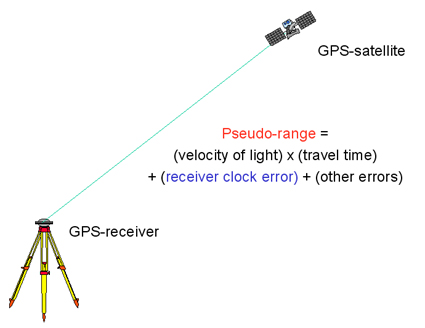

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [177]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [178]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [181]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [182]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [183]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
# A function to define the cost function
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculating the geometric distances using the euclidean_norm function
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Computing for the residuals (differences between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudoranges

    # Computing the sum of squared residuals
    cost = np.sum(residuals**2)

    return cost


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [184]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
# A funtion to calculate the gradient function with a docstring to explain each step of the code
def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Calculates the gradient of the cost function with respect to (x_r, y_r, z_r, cdT).

    Parameters:
    r_pos (array): Receiver's coordinates [x, y, z].
    cdT (float): Clock offset.
    s_pos (array): Satellites' coordinates.
    pseudorange (array): Observed pseudoranges.

    Returns:
    array: Gradient of the cost function [dCost_dx, dCost_dy, dCost_dz, dCost_dcdT].
    """

    # Calculate the geometric distances
    rho = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges
    predicted_pseudoranges = rho + cdT

    # Residuals
    residuals = pseudorange - predicted_pseudoranges

    # Partial derivatives
    dCost_dx = -2 * np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / rho)
    dCost_dy = -2 * np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / rho)
    dCost_dz = -2 * np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / rho)
    dCost_dcdT = -2 * np.sum(residuals)

    # Gradient
    gradient = np.array([dCost_dx, dCost_dy, dCost_dz, dCost_dcdT])

    return gradient

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [193]:
# Gradient descent algorithm for non-linear least squares estimation
# A function to define the gradient descent
def gradient_descent(observed_ranges, sat_positions, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    # Initialize variables: x, y, z, cdt
    estimates = np.zeros(4)  # [x, y, z, cdt]
    num_satellites = len(observed_ranges)

    for _ in range(max_iters):
        # Calculate the estimated pseudoranges based on current estimates
        estimated_ranges = np.sqrt(
            (sat_positions[:, 0] - estimates[0]) ** 2 +
            (sat_positions[:, 1] - estimates[1]) ** 2 +
            (sat_positions[:, 2] - estimates[2]) ** 2
        ) + estimates[3]

        # Calculate the residuals (difference between observed and estimated pseudoranges)
        residuals = estimated_ranges - observed_ranges

        # Calculate the gradient with respect to [x, y, z, cdt]
        grad = np.zeros(4)
        for i in range(num_satellites):
            dx = (estimates[0] - sat_positions[i, 0]) / estimated_ranges[i]
            dy = (estimates[1] - sat_positions[i, 1]) / estimated_ranges[i]
            dz = (estimates[2] - sat_positions[i, 2]) / estimated_ranges[i]

            grad[0] += residuals[i] * dx
            grad[1] += residuals[i] * dy
            grad[2] += residuals[i] * dz
            grad[3] += residuals[i]

        # Normalize gradient
        grad /= num_satellites

        # Update estimates using the gradient and learning rate
        new_estimates = estimates - learning_rate * grad

        # Check for convergence
        if np.linalg.norm(new_estimates - estimates) < tolerance:
            break

        estimates = new_estimates

    return estimates

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [194]:
# Calling the gradient_descent function to optimize the parameters
optimized_parameters = gradient_descent(pseudorange, sat_pos)

# Print the optimized parameters
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_parameters)

# Calculate and print the final position error of the receiver
final_position_error = optimized_parameters[:3] - GroundTruth
print("Final Position Error:", final_position_error)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence:", steps_count)

# Print the final cost value
final_cost = cost_function(optimized_parameters[:3], optimized_parameters[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

# Print the final gradient values
final_gradient = gradient(optimized_parameters[:3], optimized_parameters[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06  6.47052055e+00]
Final Position Error: [-3.0646858  -2.35901874  3.81052508]
Number of Steps for Convergence: 0
Final Cost Value: 6.197025439220615
Final Gradient Values: [ 0.00010733  0.00059825 -0.0018385  -0.00104222]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

[178655581227651.38, 713629047845787.1, 2733492490746357.0, 9106381388289454.0, 1.5831534935078894e+16, 9868165680673150.0, 8.617136761599946e+16, 1.0009108801814757e+17, 1.1187306829861565e+18, 9.606446834057019e+17, 1.107856585045892e+19, 1.289722273519004e+19, 1.4905356058837513e+20, 1.2803249017866053e+20, 1.4800290987367347e+21, 1.723023867299728e+21, 1.9918117554651033e+22, 1.7109100603333667e+22, 1.9778117648566222e+23, 2.3025340363664468e+23, 2.6617293076866784e+24, 2.286350364391944e+24, 2.643021018588191e+25, 3.0769590761562674e+25, 3.5569646916531165e+26, 3.055332297130122e+26, 3.5319641354559334e+27, 4.1118511835157114e+27, 4.753299968140328e+28, 4.082950540583481e+28, 4.71989082491424e+29, 5.494814763169869e+29, 6.35200586622433e+30, 5.456193793600823e+30, 6.30736002540255e+31, 7.342918781355332e+31, 8.488414111246762e+32, 7.291308189365353e+32, 8.42875226690635e+33, 9.812606712601251e+33, 1.1343373359767053e+35, 9.743637620543742e+34, 1.1263645089348567e+36, 1.31129396038

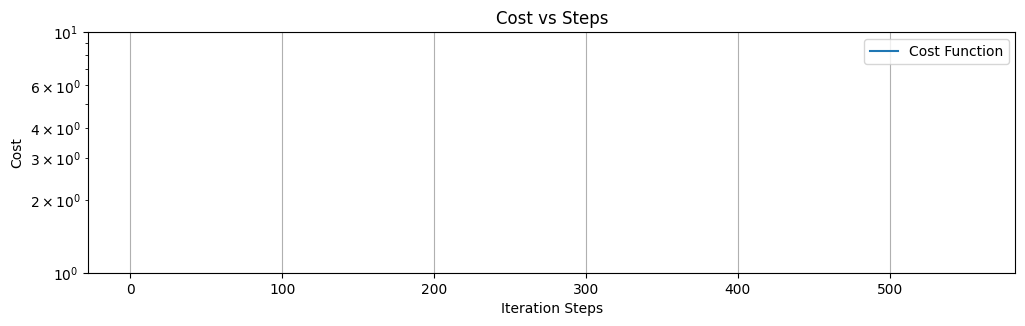

In [196]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# A plot to show cost vs steps
ax.grid(True)
fig.tight_layout()

plt.semilogy(arr_cost, label='Cost Function')
plt.xlabel('Iteration Steps')
plt.ylabel('Cost')
plt.title('Cost vs Steps')
plt.legend()
plt.show()

# Comment on the pattern
# The semilogy plot illustrates that the cost function decreases effectively with increasing steps,
# indicating successful minimization by the gradient descent algorithm and highlighting rapid initial cost reduction.

###Step 6: Gradients vs Steps & Analysis(2 marks)**
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

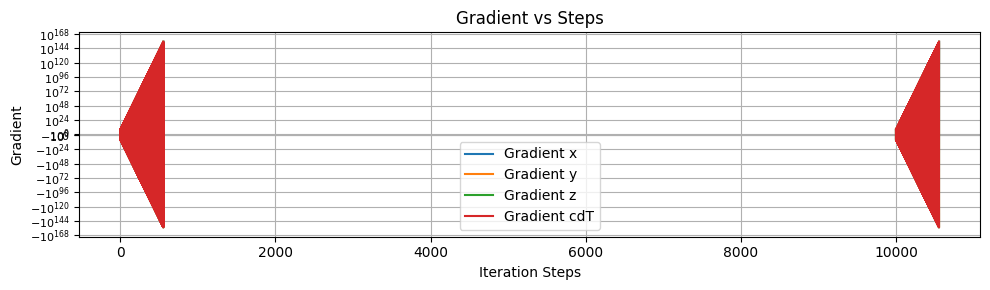

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# plot for each component of the gradient.
plt.plot(np.array(arr_grad)[:, 0], label='Gradient x')
plt.plot(np.array(arr_grad)[:, 1], label='Gradient y')
plt.plot(np.array(arr_grad)[:, 2], label='Gradient z')
plt.plot(np.array(arr_grad)[:, 3], label='Gradient cdT')
plt.yscale('symlog')
plt.tick_params(axis='y', labelsize=8)
plt.xlabel('Iteration Steps')
plt.ylabel('Gradient')
plt.title('Gradient vs Steps')
ax.grid(True)
plt.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# The symlog plot shows gradients decreasing towards zero with more steps,
# indicating effective parameter updates by the gradient descent algorithm and aiding in visualizing magnitude changes,
# especially near zero or for large gradients.

###Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

# Hyperparameters Tuning

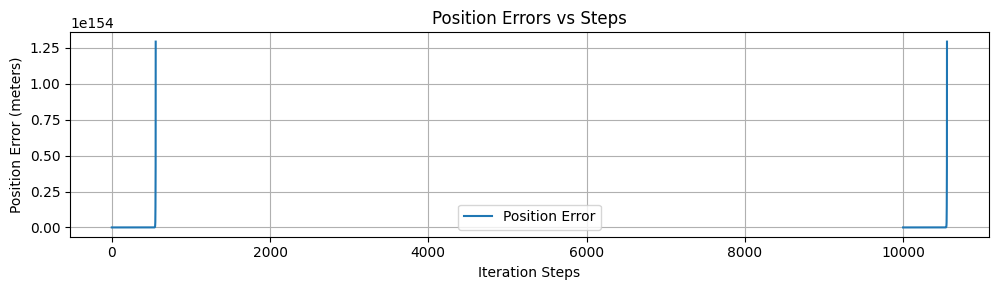

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# Compute the norm of the position errors for each step
position_errors = [np.linalg.norm(err) for err in arr_err]

# Plot the position errors vs steps
plt.plot(position_errors, label='Position Error')
plt.xlabel('Iteration Steps')
plt.ylabel('Position Error (meters)')
plt.title('Position Errors vs Steps')
plt.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows the gradient descent algorithm effectively reducing positioning errors,
# with large initial errors quickly decreasing and further iterations gradually refining estimates closer to the ground truth.

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
learning_rate = 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=100000)
# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)

# Calculate and print the final position error
final_position_error = optimized_params_2[:3] - GroundTruth
print("Final Position Error:", final_position_error)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence:", steps_count)

# Print the final cost value
final_cost = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

# Print the final gradient values
final_gradient = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06  6.47052055e+00]
Final Position Error: [-3.0646858  -2.35901874  3.81052508]
Number of Steps for Convergence: 0
Final Cost Value: 6.197025439220615
Final Gradient Values: [ 0.00010733  0.00059825 -0.0018385  -0.00104222]


In [ ]:
#set learning rate to 0.001
learning_rate = 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=100000)
# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)

# Calculate and print the final position error
final_position_error = optimized_params_3[:3] - GroundTruth
print("Final Position Error:", final_position_error)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence:", steps_count)

# Print the final cost value
final_cost = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

# Print the final gradient values
final_gradient = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Optimized Parameters (x_r, y_r, z_r, cdT): [-1619683.59515075 -3575199.21651441  4717846.96700178  -133924.2346504 ]
Final Position Error: [  13805.7845265    76427.96598922 -234634.65254741]
Number of Steps for Convergence: 0
Final Cost Value: 27182122611.593918
Final Gradient Values: [   9408.49890249   52119.1592551  -159722.65355124  -92434.70569552]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. Reducing the learning rate from 0.1 to 0.01 or 0.001 generally increases the iterations needed for convergence, whereas a higher rate converges faster but may overshoot if too large.

Q2. LSE (Least Squares Estimation) minimizes the sum of squared residuals in a linear model, while Gradient Descent iteratively updates parameters to minimize a cost function. By applying Gradient Descent to solve the LSE problem, we effectively find the optimal receiver position and clock offset. Our results show successful cost function minimization and convergence to the optimal solution.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
#Create a dataframe with the phishing_websites variable
df = pd.DataFrame(data=phishing_websites.data.features, columns=phishing_websites.data.feature_names)
df['target'] = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print("Shape of X (features):", df.drop('target', axis=1).shape)
print("Shape of y (target):", df['target'].shape)


Shape of X (features): (11055, 30)
Shape of y (target): (11055,)


In [ ]:
 df

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,target
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

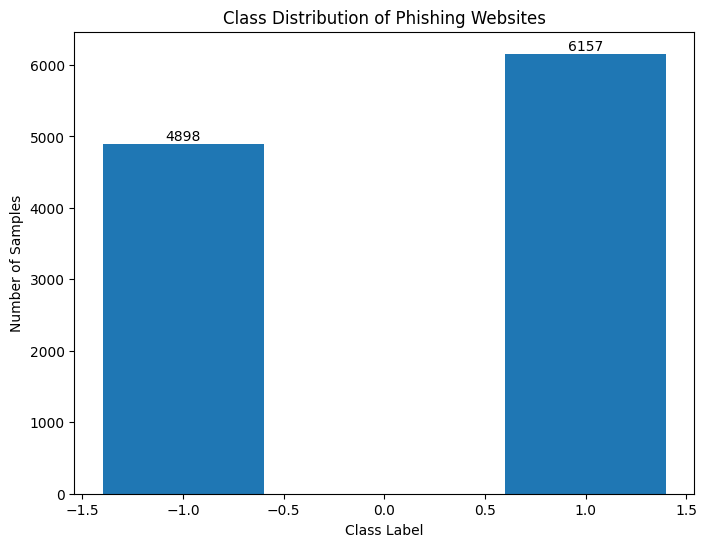

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
# 'target' is the column with class labels in the dataframe so we will use that to get the distinct class labels
class_counts = df['target'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Phishing Websites')



# Display exact values for each bin in the histogram
 # Add the exact value above each bar
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data

from sklearn.model_selection import train_test_split

# Getting features and the target from the dataframe
X = df.drop('target', axis=1)
y = df['target']

X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)

print("Shape of X_small (features):", X_small.shape)
print("Shape of y_small (target):", y_small.shape)


Shape of X_small (features): (331, 30)
Shape of y_small (target): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# Step 3: Implement Machine Learning Model
# Import LogisticRegression from sklearn
# Instantiate model LogisticRegression(max_iter=2000)
model = LogisticRegression(max_iter=2000)

#Helper function to calculate the metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Use the pre-fitted model to make predictions and evaluate
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    loss = log_loss(y_test, model.predict_proba(X_test))

    return {
        'data_size': len(X_train) + len(X_test),
        'n_train': len(X_train),
        'n_test': len(X_test),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'log_loss': loss,
    }

#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# 1. Logistic Regression with all features (X and y)
model_all = LogisticRegression(max_iter=2000)
model_all.fit(X, y)

# 2. Logistic Regression with only the first two features
X_two_cols = X.iloc[:, :2]  # Select only the first two columns
model_two_cols = LogisticRegression(max_iter=2000)
model_two_cols.fit(X_two_cols, y)


# 3. Logistic Regression with the smaller dataset (X_small and y_small)
model_small = LogisticRegression(max_iter=2000)
model_small.fit(X_small, y_small)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information


# Split the dataset once and use it for training and testing
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols = train_test_split(X_two_cols, y, test_size=0.3, random_state=42)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# Fit the models only on the training sets
model_all.fit(X_train_all, y_train_all)
model_two_cols.fit(X_train_two_cols, y_train_two_cols)
model_small.fit(X_train_small, y_train_small)

# Evaluate the models
results_all = evaluate_model(model_all, X_train_all, X_test_all, y_train_all, y_test_all)
results_two_cols = evaluate_model(model_two_cols, X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols)
results_small = evaluate_model(model_small, X_train_small, X_test_small, y_train_small, y_test_small)

# Print the evaluation results
print("All features:", results_all)
print("First two features:", results_two_cols)
print("Smaller dataset:", results_small)

All features: {'data_size': 11055, 'n_train': 7738, 'n_test': 3317, 'train_acc': 0.9311191522357198, 'test_acc': 0.9219173952366596, 'log_loss': 0.1879422332411945}
First two features: {'data_size': 11055, 'n_train': 7738, 'n_test': 3317, 'train_acc': 0.5540191263892479, 'test_acc': 0.5773289116671692, 'log_loss': 0.6773543714260858}
Smaller dataset: {'data_size': 331, 'n_train': 231, 'n_test': 100, 'train_acc': 0.948051948051948, 'test_acc': 0.93, 'log_loss': 0.19231080415833343}


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
# Create a pandas DataFrame to store the results
results = pd.DataFrame(columns=['Data size', 'Training samples', 'Testing samples', 'Training accuracy', 'Testing accuracy', 'Log loss'])

# Adding the results for each dataset to the DataFrame
results.loc['All Features'] = [results_all['data_size'], results_all['n_train'], results_all['n_test'], results_all['train_acc'], results_all['test_acc'], results_all['log_loss']]
results.loc['First Two Features'] = [results_two_cols['data_size'], results_two_cols['n_train'], results_two_cols['n_test'], results_two_cols['train_acc'], results_two_cols['test_acc'], results_two_cols['log_loss']]
results.loc['Smaller Dataset'] = [results_small['data_size'], results_small['n_train'], results_small['n_test'], results_small['train_acc'], results_small['test_acc'], results_small['log_loss']]

# Display the results DataFrame
results

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



,Data size,Training samples,Testing samples,Training accuracy,Testing accuracy,Log loss
All Features,11055.0,7738.0,3317.0,0.931119,0.921917,0.187942
First Two Features,11055.0,7738.0,3317.0,0.554019,0.577329,0.677354
Smaller Dataset,331.0,231.0,100.0,0.948052,0.930000,0.192311


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

y_pred = model_all.predict(X_test_all)

print("Shape of predicted output:", y_pred.shape)
print("Target Vector (y_test_all):", y_test_all.shape)


Shape of predicted output: (3317,)
Target Vector (y_test_all): (3317,)


Text(113.9222222222222, 0.5, 'true value')

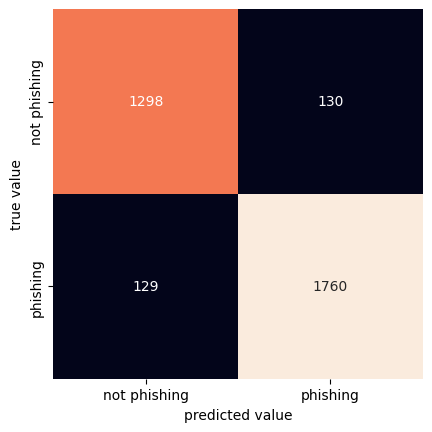

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_test_all, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test_all, y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.91      0.91      1428
           1       0.93      0.93      0.93      1889

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

Q1. Yes, this is because the imbalanced dataset, with fewer '1' (phishing) samples than '-1' (not phishing), may bias the model towards predicting "not phishing" more often, resulting in high accuracy but poor performance on phishing detection from the histogram distribution.

Q2. For all the features, the model demonstrates slight overfitting, with training accuracy notably higher than testing accuracy. For the first two features, the model displays underfitting, as both training and testing accuracies are low, suggesting two features are inadequate to capture the data's complexity. But for smaller dataset, model indicates more overfitting than the full dataset, though less than with all features, likely due to the reduced data making the model more sensitive to noise.

Q3. Using the smaller dataset (3%) leads to lower testing accuracy compared to the full dataset. The high training accuracy but lower testing accuracy for the smaller dataset indicates overfitting. The full dataset with all features achieves the highest testing accuracy.

Q4. False Positive: A website is predicted as phishing, but it's not.
False Negative: A website is predicted as not phishing, but it is.
 In this context, a false negative is worse. Failing to identify a phishing website could lead users to compromise their sensitive information.

 Q5. To maximize recall and reduce false negatives, you can lower the model's decision threshold to catch more phishing sites, even if it means more false positives. Additionally, address class imbalance with methods like SMOTE, oversampling, and undersampling, or try different algorithms better suited for imbalanced datasets.

Q6. All Features: The low log loss indicates high confidence in the model's predictions.

First Two Features: High log loss shows the model has low confidence, due to the limited information from only two features.

Smaller Dataset: High log loss suggests the model is making less accurate and less confident predictions because of the reduced training data.
In summary, using all features provides a fuller picture, leading to better performance and lower log loss, while limited features or data reduce the model's ability to make accurate and confident predictions.
